## Importing Libraries

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import warnings
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import GridSearchCV,train_test_split
from xgboost import XGBClassifier
import lightgbm
from imblearn.over_sampling import SMOTE

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


## Preprocessing

In [0]:
path = "./drive/My Drive/data/"
train_path = path+"Train.csv"
test_path = path+"Test.csv"

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
train_df.head()

In [0]:
test_df.sample(5)

1st column is ID and Second columns is Target variable

In [7]:
train_df.shape, test_df.shape

((17521, 2395), (20442, 2394))

## Preprocessing 

In [0]:
# Check columns for Null values
def null_cols(d,columns):
  na = d[columns].isna().sum().sort_values(ascending=False)
  return na[na > 0].index.to_list()

In [0]:
# Replace all null values 
def replace_null(X,cols):
  na_cols = null_cols(X,cols)
  print('1.Null columns',len(na_cols))

  if len(na_cols) > 0:
    X[na_cols]= X[na_cols].fillna(method='ffill')
    X[na_cols]= X[na_cols].fillna(method='bfill')
    na_cols = null_cols(X,cols)
    print('2.Null columns',len(na_cols))

## Feature Selection (X,Y)

In [0]:
target = 'Col2'
num_cols = train_df.select_dtypes(include="number").columns
cat_cols = list(set(train_df.columns) - set(num_cols))
corr = train_df.corr()

Index(['Col2', 'Col440', 'Col636', 'Col243', 'Col437', 'Col627', 'Col431',
       'Col234', 'Col240', 'Col380', 'Col183', 'Col1502', 'Col1322', 'Col577',
       'Col1412', 'Col2232', 'Col2052', 'Col1592', 'Col2142', 'Col2322',
       'Col913', 'Col914', 'Col166', 'Col915', 'Col677', 'Col1364', 'Col877',
       'Col1544', 'Col1454', 'Col1634', 'Col51', 'Col2094', 'Col633',
       'Col2274', 'Col876', 'Col2184', 'Col135', 'Col2364', 'Col38', 'Col59',
       'Col330', 'Col527', 'Col127', 'Col193', 'Col390', 'Col178', 'Col875',
       'Col874', 'Col180', 'Col186'],
      dtype='object')
1.Null columns 23
2.Null columns 0


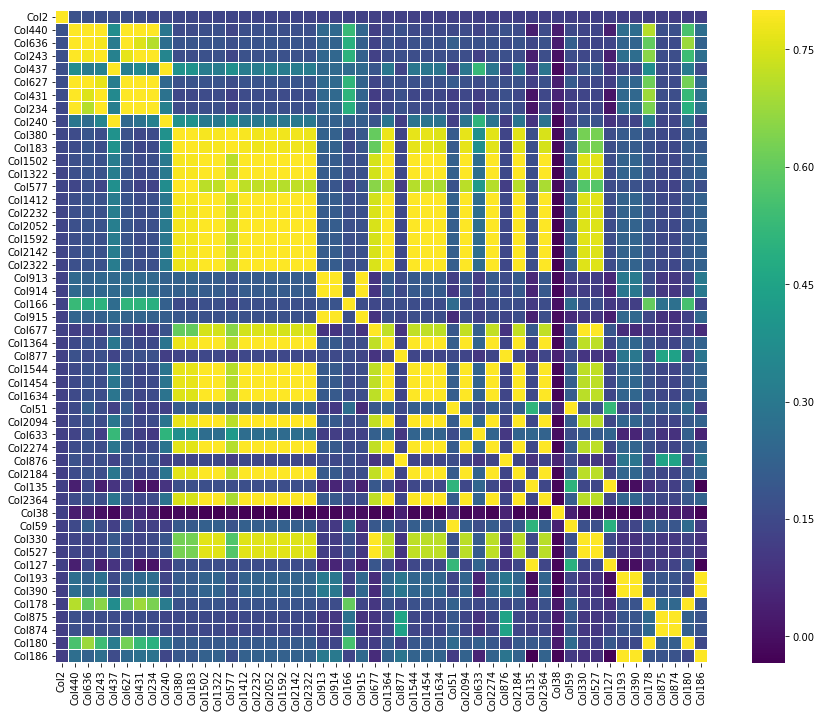

In [262]:
k= 50
cols = corr.nlargest(k,target)[target].index
print(cols)
# cm = np.corrcoef(train_df[cols].values.T)
cm = train_df.loc[:,cols].corr()
f , ax = plt.subplots(figsize = (16,12))

col_x = list(set(cols) - set([target]))
X, Y = train_df.loc[:,col_x] ,train_df.loc[:,target]
replace_null(X,col_x)

sns.heatmap(cm, vmax=.8, linewidths=0.01,square=True,annot=False,cmap='viridis',
            linecolor="white",xticklabels = cols.values ,annot_kws = {'size':12},yticklabels = cols.values)

In [0]:
def generate_accuracy_and_heatmap(model, x, y):
    ac = accuracy_score(y,model.predict(x))
    f_score = f1_score(y,model.predict(x))
    print('Accuracy is: ', ac)
    print('F1 score is: ', f_score)
    print ("\n")
#     print (pd.crosstab(pd.Series(model.predict(x), name='Predicted'),
#                        pd.Series(y.loc[:,target],name='Actual')))
    pass

## SMOTE

In [264]:
# X, Y = train_df.drop(columns=[target]) ,train_df.loc[:,target]
print('Before OverSampling, the shape of train_X: {}'.format(X.shape))
print('Before OverSampling, the shape of train_y: {} \n'.format(Y.shape))

sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X, Y)

print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res==1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res==0)))

Before OverSampling, the shape of train_X: (17521, 49)
Before OverSampling, the shape of train_y: (17521,) 

After OverSampling, the shape of train_X: (31520, 49)
After OverSampling, the shape of train_y: (31520,) 

After OverSampling, counts of label '1': 15760
After OverSampling, counts of label '0': 15760


## Modeling

### Logistic Regression

In [150]:
clf_lr = LogisticRegression()      
lr_baseline_model = clf_lr.fit(X, Y)
generate_accuracy_and_heatmap(lr_baseline_model, X, Y)

Accuracy is:  0.8994920381256778
F1 score is:  0.06180074587107085




In [0]:
pd.crosstab(clf_lr.predict(X),Y,rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,15711,1724
1,49,37


### XGBoost

In [265]:
# fit model no training data
model = XGBClassifier(learning_rate=1,n_jobs=4)
model.fit(X, Y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=4, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [266]:
y_pred = model.predict(X)
predictions = [round(value) for value in Y]
pd.crosstab(y_pred,Y,rownames=['Predicted'], colnames=['Actual'])

Actual,0,1
Predicted,,
0,15671,1103
1,89,658


In [267]:
generate_accuracy_and_heatmap(model, X, Y)

Accuracy is:  0.9319673534615605
F1 score is:  0.5247208931419458




### LightGBM

In [259]:
# parameters = {
#     'application': 'binary',
#     'objective': 'binary',
#     'metric': 'auc',
#     'is_unbalance': 'true',
#     'boosting': 'gbdt',
#     'num_leaves': 31,
#     'feature_fraction': 0.5,
#     'bagging_fraction': 0.5,
#     'bagging_freq': 20,
#     'learning_rate': 0.05,
#     'verbose': 0
# }

# x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# categorical_features = [c for c, col in enumerate(X.columns) if 'cat' in col]
# train_data = lightgbm.Dataset(x, label=y, categorical_feature=categorical_features)
# test_data = lightgbm.Dataset(x_test, label=y_test)


# model = lightgbm.train(parameters,
#                        train_data,
#                        valid_sets=test_df,
#                        num_boost_round=5000,
#                        early_stopping_rounds=100)

# y_pred = model.predict(X)
# predictions = [round(value) for value in Y]

# generate_accuracy_and_heatmap(model, X, Y)
# pd.crosstab(y_pred,Y,rownames=['Predicted'], colnames=['Actual'])

TypeError: ignored

## Hyperparameter tuning

### Logistic regression

In [134]:
weights = np.linspace(0.05, 0.95, 20)
gsc = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=5
)

grid_result = gsc.fit(X, Y)
print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'class_weight': {0: 0.14473684210526316, 1: 0.8552631578947368}}


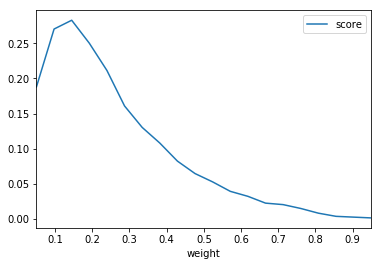

In [135]:
data_out = pd.DataFrame({'score': grid_result.cv_results_['mean_test_score'],
                       'weight': weights })
data_out.plot(x='weight')

In [142]:
clf = LogisticRegression(**grid_result.best_params_).fit(X, Y)
print(clf)
y1 = clf.predict(X)


# Confusion matrix
pd.crosstab(y1,Y,rownames=['Predicted'], colnames=['Actual'])

LogisticRegression(C=1.0,
                   class_weight={0: 0.14473684210526316, 1: 0.8552631578947368},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None,
                   penalty='l2', random_state=None, solver='warn', tol=0.0001,
                   verbose=0, warm_start=False)


Actual,0,1
Predicted,,
0,14037,1183
1,1723,578


## Submission

In [268]:
test_df.loc[:,col_x] = test_df.loc[:,col_x].fillna(method='ffill')
test_df.loc[:,col_x].isna().sum().sort_values(ascending=False)

Col914     1
Col38      1
Col874     1
Col876     1
Col877     1
Col677     1
Col527     1
Col915     1
Col875     1
Col330     1
Col913     1
Col390     0
Col1502    0
Col380     0
Col431     0
Col51      0
Col2052    0
Col2364    0
Col636     0
Col240     0
Col180     0
Col1412    0
Col440     0
Col1544    0
Col1364    0
Col2232    0
Col243     0
Col1454    0
Col2142    0
Col183     0
Col437     0
Col2094    0
Col1592    0
Col1322    0
Col627     0
Col633     0
Col1634    0
Col193     0
Col59      0
Col2322    0
Col127     0
Col166     0
Col234     0
Col178     0
Col2184    0
Col577     0
Col2274    0
Col186     0
Col135     0
dtype: int64

In [269]:
sample = pd.read_csv(path+'Sample_submission.csv')
# y_test = clf_lr.predict(test_df.loc[:,col_x])
y_test = model.predict(test_df.loc[:,col_x])
print(sum(y_test))

994


In [0]:
sample.drop(index=sample.index,inplace=True)
sample['Col1'] = test_df.iloc[:,0]
sample['Col2'] = y_test 
sample.to_csv('out.csv',index=False)